In this documents, we'll check if all the library has been correctly installed. 

In [160]:
# -- IMPORTS START --
import matplotlib
import matplotlib.pyplot as plt

import os
import re
import warnings
import datetime
import pathlib
import glob
import numpy as np
import pandas as pd
import joblib
from scipy import signal
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn import tree


from scipy.signal import butter, filtfilt, find_peaks
# -- IMPORTS END --

# enable zooming into graphs
%matplotlib inline
plt.rcParams['figure.figsize'] = [9, 6] # width, height in inches

# Part 1: Define Helper Functions

In [ ]:
# These helper functions exist to help avoid menually adding dictionary entries for each features every time.

def row_features(feature_strs, source):
    new_row = {}
    for feature_str in feature_strs:
        new_row[feature_str] = source[feature_str]
    return new_row
def row_features_iloc(feature_strs, source):
    new_row = {}
    for feature_str in feature_strs:
        new_row[feature_str] = source.iloc[0][feature_str]
    return new_row
feature_list = ['avg', 'max', 'med', 'min', 'q25', 'q75', 'std', 'avg_roll', 'max_roll', 'med_roll', 'min_roll', 'q25_roll', 'q75_roll', 'std_roll', 'avg_pitch', 'max_pitch', 'med_pitch', 'min_pitch', 'q25_pitch', 'q75_pitch', 'std_pitch', 'avg_yaw', 'max_yaw', 'med_yaw', 'min_yaw', 'q25_yaw', 'q75_yaw', 'std_yaw']

In [40]:
def plot_xyz(data):

    # Set axis
    axis = ['x', 'y', 'z']

    # Generate datetime index
    start = pd.Timestamp('2023-01-01')

    fig, axs = plt.subplots(ncols=3, nrows=1)

    for i in range(len(axis)):

        # Select random window
        start = 0
        end = 10 * 100
        window = data.iloc[start:end]

        ax = axs.flat[i]

        # Plot data
        ax.set_xticklabels([])        
        ax.plot(window.index, window[axis[i]], label=axis[i])

        # Plot peaks
        # peak_mask = window['peaks'] != 0
        # ax.plot(window.index[peak_mask], window['accel_mag'][peak_mask], 'ro', label='Peaks')

        ax.legend()
        ax.set_title(f"Axis-{axis[i]}")

    fig.tight_layout()
    fig.show()

In [41]:
# Helper function to visualize model
def viz_tree(dt_model,features_frames,cnames):
    # Fix feature names as list
    feature_names = features_frames.columns.tolist()

    fig, ax = plt.subplots(figsize=(9,4))
    tree.plot_tree(dt_model,
                   feature_names=feature_names,
                   fontsize=7,
                   class_names=cnames,
                   filled=True,
                   ax=ax)

    plt.title('Decision Tree')
    plt.savefig('dt.png')

In [42]:
def calc_magnitude(data):

    # Calculate magnitude
    data['accel_mag'] = np.sqrt(data['accelerationX']**2 + data['accelerationY']**2 + data['accelerationZ']**2) # absolute accel magnitude
    data['accel_mag'] = data['accel_mag'] - data['accel_mag'].mean() # detrend: "remove gravity"

    return data

In [43]:
def remove_noise(data,sampling_rate):
    from scipy.signal import butter, filtfilt, find_peaks

    # Low pass filter
    cutoff = 5 # Hz
    order = 2
    b, a = butter(order, cutoff/(sampling_rate/2), btype='lowpass')
    data['filtered_accel_mag'] = filtfilt(b, a, data['accel_mag'])

    return data

In [53]:
def add_features(window):
    features = {}

    # Filtered acceleration magnitude features
    features['avg'] = window['filtered_accel_mag'].mean()
    features['max'] = window['filtered_accel_mag'].quantile(1)
    features['med'] = window['filtered_accel_mag'].quantile(0.5)
    features['min'] = window['filtered_accel_mag'].quantile(0)
    features['q25'] = window['filtered_accel_mag'].quantile(0.25)
    features['q75'] = window['filtered_accel_mag'].quantile(0.75)
    features['std'] = window['filtered_accel_mag'].std()

    # Roll features
    features['avg_roll'] = window['roll'].mean()
    features['max_roll'] = window['roll'].quantile(1)
    features['med_roll'] = window['roll'].quantile(0.5)
    features['min_roll'] = window['roll'].quantile(0)
    features['q25_roll'] = window['roll'].quantile(0.25)
    features['q75_roll'] = window['roll'].quantile(0.75)
    features['std_roll'] = window['roll'].std()

    # Pitch features
    features['avg_pitch'] = window['pitch'].mean()
    features['max_pitch'] = window['pitch'].quantile(1)
    features['med_pitch'] = window['pitch'].quantile(0.5)
    features['min_pitch'] = window['pitch'].quantile(0)
    features['q25_pitch'] = window['pitch'].quantile(0.25)
    features['q75_pitch'] = window['pitch'].quantile(0.75)
    features['std_pitch'] = window['pitch'].std()

    # Yaw features
    features['avg_yaw'] = window['yaw'].mean()
    features['max_yaw'] = window['yaw'].max()
    features['med_yaw'] = window['yaw'].quantile(0.5)
    features['min_yaw'] = window['yaw'].quantile(0)
    features['q25_yaw'] = window['yaw'].quantile(0.25)
    features['q75_yaw'] = window['yaw'].quantile(0.75)
    features['std_yaw'] = window['yaw'].std()

    df = pd.DataFrame()
    df = df._append(features,ignore_index=True)
    return df

In [170]:
def train_decision_tree(frames):
    # Extract feature columns
    X = frames[feature_list]

    # Extract target column
    y = frames['activity']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    # Create model
    dt_model = DecisionTreeClassifier(criterion='entropy',max_depth=7).fit(X_train, y_train)
    dt_pred = dt_model.predict(X_test)

    # Evaluate on test set
    acc = dt_model.score(X_test, y_test)
    dt_cm = confusion_matrix(y_test, dt_pred, labels=dt_model.classes_)
    print(classification_report(y_test, dt_pred))
    print("Accuracy on test set:", acc)

    return dt_model,dt_cm,acc

In [47]:
# Function to extract windows and features
def extract_features(data, window_sec, sample_rate, activity):
	window_str = f"{window_sec}s"
	data['time'] = pd.to_datetime(data['time'])
	data.set_index('time', inplace=True)
	resampled_data = data.resample(window_str)
	all_features = []
	for time, window in resampled_data:
		features = add_features(window)
		new_row = row_features_iloc(feature_list, features)
		new_row['activity'] = activity
		all_features.append(new_row)
	return pd.DataFrame(all_features)

In [168]:
def all_data_to_combined_csv(root, output_filename = 'all_data.csv'):
    all_data = []
    sampling_rate = 100
    window_sec = 5

    
    activity_folders = os.listdir(root)
    for folder in activity_folders:
        activity_files = glob.glob(f"{root}/{folder}/*.csv")

        for file in activity_files:
            df = pd.read_csv(file, parse_dates=['time'])
            df = calc_magnitude(df)
            df = remove_noise(df, sampling_rate)
            df_features = extract_features(df, window_sec, sampling_rate, folder)

            for index, row in df_features.iterrows():
                new_row = row_features(feature_list, row)
                new_row['activity'] = row['activity']
                all_data.append(new_row)

    all_data = pd.DataFrame(all_data)
    all_data.to_csv(f"{root}/{output_filename}")  
    return all_data

# Part 2: Collect Training Data Into A Combined CSV

In [171]:
def transform_time_to_datetime(root):
    
    dateparse = lambda dates: [pd.to_datetime(d, unit='ns') for d in dates]
    # Get list of all activity folders
    activity_folders = os.listdir(root)
    # print(activity_folders)

    for folder in activity_folders:
        # print(folder)
        files = glob.glob(f"{root}/{folder}/*.csv")
        for filename in files:
            # print(filename)
            df = pd.read_csv(filename, parse_dates=['time'])
            df['time'] = pd.to_datetime(pd.to_numeric(df['time']), unit='ns')
            df.to_csv(filename, index=False)
warnings.filterwarnings('ignore')
transform_time_to_datetime('data/training_data')
transform_time_to_datetime('data/training_data_binary_labels')

all_data_to_combined_csv('data/training_data', 'all_data.csv')
all_data_to_combined_csv('data/training_data_binary_labels', 'all_data_binary.csv')


,avg,max,med,min,q25,q75,std,avg_roll,max_roll,med_roll,...,q75_pitch,std_pitch,avg_yaw,max_yaw,med_yaw,min_yaw,q25_yaw,q75_yaw,std_yaw,activity
0,0.001866,0.002902,0.001908,0.000743,0.001327,0.002452,0.000861,-0.318436,-0.314481,-0.319046,...,-0.414906,0.002024,-0.075803,-0.066953,-0.077048,-0.081259,-0.078666,-0.075091,0.005439,good_posture
1,-0.000320,0.003275,-0.000808,-0.001930,-0.001202,0.000637,0.001282,-0.324921,-0.321710,-0.325080,...,-0.397360,0.006773,-0.075250,-0.072074,-0.074243,-0.082915,-0.076880,-0.073372,0.002857,good_posture
2,-0.000877,0.000328,-0.000904,-0.002020,-0.001325,-0.000473,0.000551,-0.325807,-0.321269,-0.325991,...,-0.420190,0.004048,-0.066047,-0.060794,-0.064768,-0.072538,-0.069796,-0.062962,0.003854,good_posture
3,-0.000234,0.003282,-0.000504,-0.001633,-0.000946,0.000079,0.001068,-0.317908,-0.302187,-0.318778,...,-0.430233,0.001459,-0.052723,-0.045861,-0.051470,-0.062297,-0.055524,-0.048598,0.005267,good_posture
4,0.000334,0.001883,0.000228,-0.001463,-0.000228,0.001029,0.000854,-0.317717,-0.304668,-0.318792,...,-0.431660,0.002737,-0.059619,-0.055817,-0.059381,-0.064906,-0.061297,-0.057921,0.002066,good_posture
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,-0.001811,0.000992,-0.001927,-0.003216,-0.002337,-0.001689,0.000941,0.058804,0.063557,0.059452,...,-0.227188,0.002394,-0.069301,-0.061846,-0.069099,-0.086921,-0.070536,-0.065280,0.005187,bad_posture
478,0.004151,0.016783,0.003112,-0.002305,-0.000816,0.007709,0.005421,0.029951,0.050050,0.028907,...,-0.209376,0.025490,-0.101915,-0.081035,-0.102687,-0.125019,-0.106807,-0.095141,0.011461,bad_posture
479,0.000803,0.004035,0.000477,-0.001695,-0.000362,0.001751,0.001494,0.018658,0.034700,0.024380,...,-0.211975,0.013723,-0.106192,-0.086264,-0.103572,-0.130661,-0.112975,-0.099196,0.010185,bad_posture
480,0.002817,0.013458,0.000387,-0.002212,-0.000922,0.006015,0.004595,-0.025419,0.002782,-0.023918,...,-0.229828,0.016835,-0.088354,-0.065758,-0.087191,-0.125465,-0.095012,-0.080002,0.012947,bad_posture


# Part 3: Train Decision Tree

In [172]:
feature_frames = pd.read_csv('data/training_data/all_data.csv')
dt_model, dt_cm, acc = train_decision_tree(feature_frames)

feature_frames_binary = pd.read_csv('data/training_data_binary_labels/all_data_binary.csv')
dt_model_binary, dt_cm_binary, acc_binary = train_decision_tree(feature_frames_binary)


                    precision    recall  f1-score   support

   bad_back_slouch       0.94      0.94      0.94        17
bad_back_tall_arch       0.88      0.82      0.85        17
          bad_neck       0.90      0.90      0.90        10
      good_posture       0.67      0.80      0.73         5

          accuracy                           0.88        49
         macro avg       0.85      0.87      0.85        49
      weighted avg       0.88      0.88      0.88        49

Accuracy on test set: 0.8775510204081632
              precision    recall  f1-score   support

 bad_posture       0.97      1.00      0.98        32
good_posture       1.00      0.94      0.97        17

    accuracy                           0.98        49
   macro avg       0.98      0.97      0.98        49
weighted avg       0.98      0.98      0.98        49

Accuracy on test set: 0.9795918367346939


Print confusion matrices

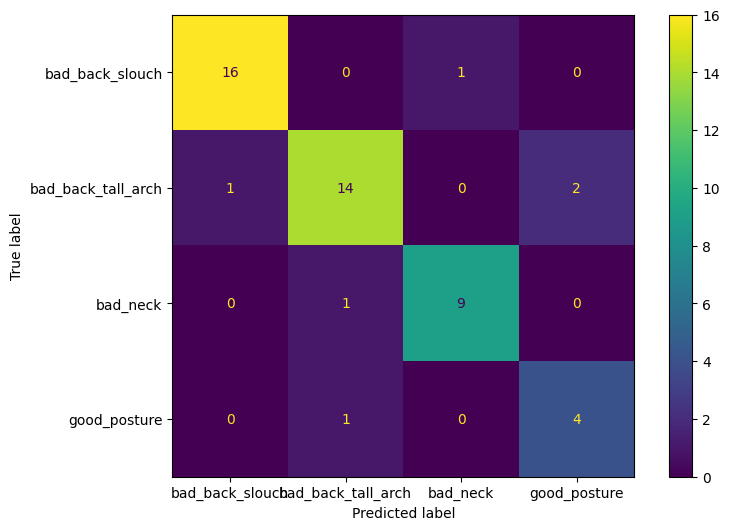

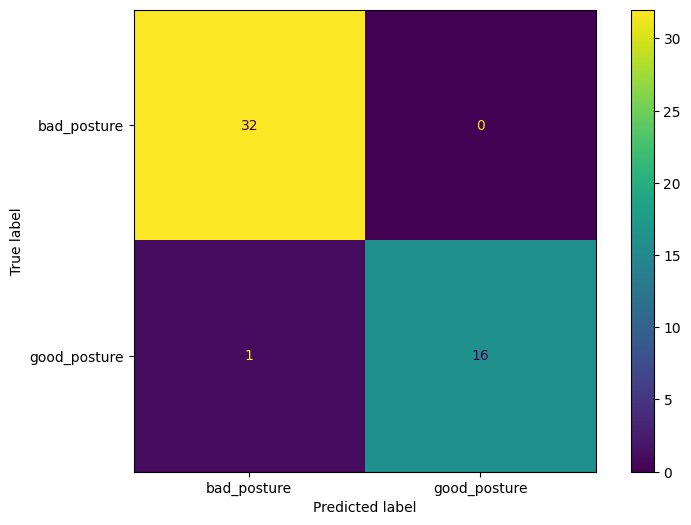

In [173]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = dt_cm, display_labels=dt_model.classes_)
cm_display.plot()
plt.show()

cm_display_binary = ConfusionMatrixDisplay(confusion_matrix=dt_cm_binary, display_labels=dt_model_binary.classes_)
cm_display_binary.plot()
plt.show()